## Malaria Diagnosis - Convulational Neural Network

Importing the Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers, losses, optimizers

In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Preparation

Importing the Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, shuffle_files=True, as_supervised=True, split=['train'])
print(dataset, dataset_info)

[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>] tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Muhammad Ahsan\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@articl

In [4]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [5]:
print(len(dataset[0]))

27558


Defining the Train, Validation and Test Datasets Ratios

In [6]:
def split_up(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE)).take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))).take(int(TEST_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


Splitting up the Dataset

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [8]:
train_dataset, val_dataset, test_dataset = split_up(dataset[0], 0.8, 0.1, 0.1)
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

### Visualizing the Dataset

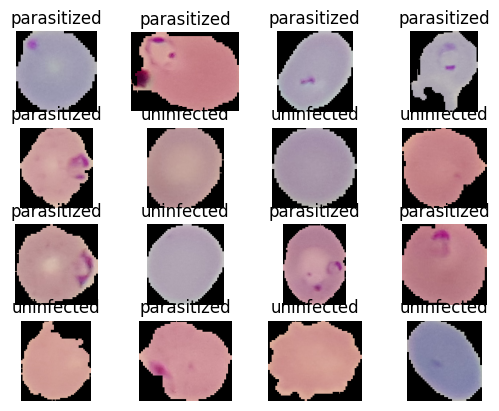

In [9]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

### Data Processing

Image Resizing and Rescaling

In [10]:
IMG_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, label

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

Shuffling the Data

In [12]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Model Creation

Designing

In [15]:
# Initial Model
# lenet_model = keras.Sequential([
#     layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

#     layers.Conv2D(filters=6, kernel_size=5, strides=1, activation='relu',padding='valid'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=2, strides=2),

#     layers.Conv2D(filters=16, kernel_size=5, padding='valid', strides=1,activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=2, strides=2),

#     layers.Flatten(),

#     layers.Dense(100, activation='relu'),
#     layers.BatchNormalization(),

#     layers.Dense(10, activation='relu'),
#     layers.BatchNormalization(),

#     layers.Dense(1, activation='sigmoid')
# ])


# Model with reduced kernel size
lenet_model = keras.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(filters=6, kernel_size=3, strides=1, activation='relu',padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2, strides=2),

    layers.Conv2D(filters=16, kernel_size=3, padding='valid', strides=1,activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2, strides=2),

    layers.Flatten(),

    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid')
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     6

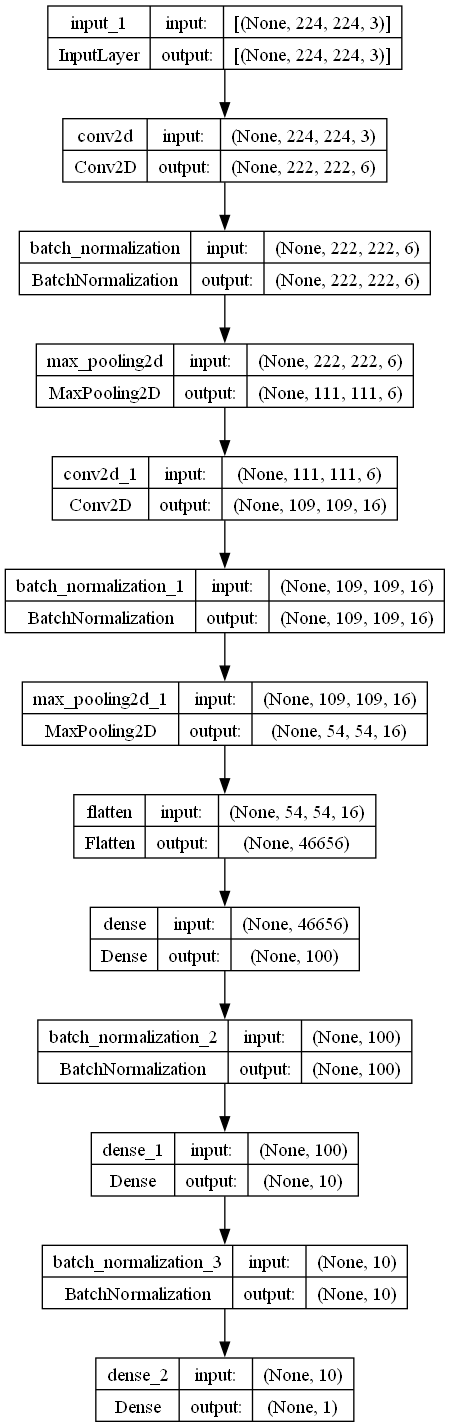

In [16]:
keras.utils.plot_model(lenet_model, to_file='model.png', show_shapes=True)

Compiling

In [17]:
lenet_model.compile(
    loss = losses.BinaryCrossentropy(),
    optimizer = optimizers.Adam(learning_rate=0.01),
    metrics='accuracy'
)

Training

In [18]:
history = lenet_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
689/689 [==============================] - 42s 50ms/step - loss: 0.3618 - accuracy: 0.8405 - val_loss: 0.3210 - val_accuracy: 0.9038
Epoch 2/20
689/689 [==============================] - 32s 46ms/step - loss: 0.2157 - accuracy: 0.9286 - val_loss: 0.3639 - val_accuracy: 0.8559
Epoch 3/20
689/689 [==============================] - 32s 46ms/step - loss: 0.1949 - accuracy: 0.9330 - val_loss: 0.2898 - val_accuracy: 0.9089
Epoch 4/20
689/689 [==============================] - 33s 48ms/step - loss: 0.1890 - accuracy: 0.9355 - val_loss: 0.4819 - val_accuracy: 0.6780
Epoch 5/20
689/689 [==============================] - 36s 52ms/step - loss: 0.2027 - accuracy: 0.9299 - val_loss: 0.3275 - val_accuracy: 0.8759
Epoch 6/20
689/689 [==============================] - 36s 52ms/step - loss: 0.1800 - accuracy: 0.9390 - val_loss: 0.2384 - val_accuracy: 0.9216
Epoch 7/20
689/689 [==============================] - 35s 51ms/step - loss: 0.1613 - accuracy: 0.9471 - val_loss: 0.1825 - val_accuracy:

Visualizing the Model's Loss

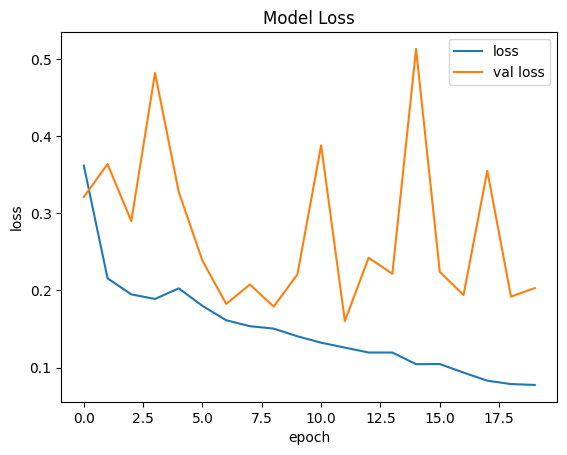

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val loss'])
plt.savefig('model_loss.png')
plt.show()

Visualizing the Model's Accuracy

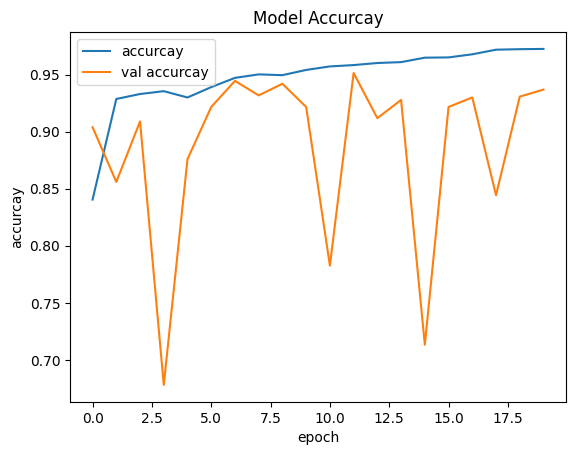

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accurcay')
plt.xlabel('epoch')
plt.ylabel('accurcay')
plt.legend(['accurcay', 'val accurcay'])
plt.savefig('model_accuracy.png')
plt.show()

### Validation and Testing

Evaluating the Model

In [21]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
lenet_model.evaluate(test_dataset)

2755/2755 [==============================] - 16s 5ms/step - loss: 0.2276 - accuracy: 0.9274


[0.2275528609752655, 0.9274047017097473]

Predicting the Test Values

In [35]:
def parasite_or_not(x):
    if x<0.5:
        return 'Infected'
    else:
        return 'Uninfected'


In [24]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 2s 2s/step


'U'

In [25]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    print(label)

tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([0], shape=(1,), dtype=int64)
tf.Tensor([0], shape=(1,), dtype=int64)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([0], shape=(1,), dtype=int64)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([0], shape=(1,), dtype=int64)


1/1 [==============================] - 0s 16ms/step


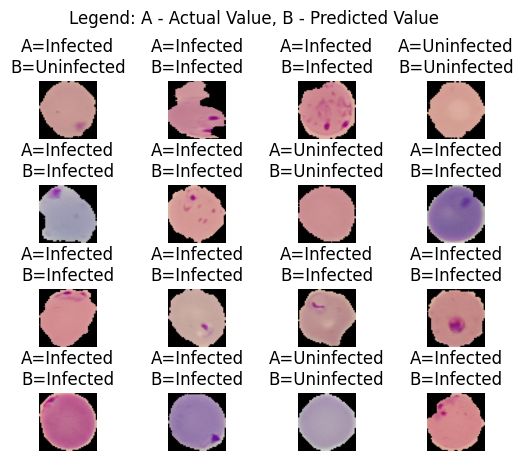

In [49]:
fig, ax = plt.subplots()
plt.axis('off')

# Adding the legend at the top of the plot
plt.figtext(0.5, 1, "Legend: A - Actual Value, B - Predicted Value", ha="center", fontsize=12)

plt.subplots_adjust(hspace=0.8)

# Plotting images
for i, (image, label) in enumerate(test_dataset.take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image[0])
    actual_value = parasite_or_not(label.numpy()[0])
    predicted_value = parasite_or_not(lenet_model.predict(image)[0][0])
    plt.title(f"A={actual_value}\nB={predicted_value}")
    plt.axis('off')

# Display the plot
plt.savefig('images/results.png')
plt.show()